In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import keras
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses
from sklearn.utils import shuffle

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df_gld = pd.read_csv("gld_price_data.csv")
print(df_gld.head())

       Date          SPX        GLD        USO     SLV   EUR/USD
0  1/2/2008  1447.160034  84.860001  78.470001  15.180  1.471692
1  1/3/2008  1447.160034  85.570000  78.370003  15.285  1.474491
2  1/4/2008  1411.630005  85.129997  77.309998  15.167  1.475492
3  1/7/2008  1416.180054  84.769997  75.500000  15.053  1.468299
4  1/8/2008  1390.189941  86.779999  76.059998  15.590  1.557099


In [3]:
def fill_missing_values(df, column):
    # Lặp qua từng giá trị trong cột, tìm các giá trị thiếu (NaN)
    for idx in range(1, len(df) - 1):
        if pd.isna(df.loc[idx, column]):
            # Tìm giá trị trước đó không bị thiếu
            prev_idx = idx - 1
            while prev_idx >= 0 and pd.isna(df.loc[prev_idx, column]):
                prev_idx -= 1
            
            # Tìm giá trị sau đó không bị thiếu
            next_idx = idx + 1
            while next_idx < len(df) and pd.isna(df.loc[next_idx, column]):
                next_idx += 1

            # Nếu tìm được giá trị trước và sau, áp dụng công thức nội suy
            if prev_idx >= 0 and next_idx < len(df):
                a_value = df.loc[prev_idx, column]
                b_value = df.loc[next_idx, column]
                index_a = prev_idx
                index_b = next_idx
                index_x = idx

                # Công thức nội suy tuyến tính
                x_value = a_value + (index_x - index_a) / (index_b - index_a) * (b_value - a_value)
                
                # Điền giá trị đã tính vào vị trí thiếu
                df.loc[idx, column] = x_value

    return df
    
def fill_missing_values_date(df, date, column):
    # Tạo DataFrame với tất cả các ngày (bao gồm cả thứ 7, chủ nhật)
    all_days = pd.date_range(start=df[date].min(), end=df[date].max(), freq='D')
    df_all = pd.DataFrame({date: all_days})
    
    # Kết hợp dữ liệu gốc với DataFrame chứa tất cả các ngày
    df_merged = pd.merge(df_all, df, on=date, how='left')
    df_merged['index'] = range(1, len(df_merged) + 1)
    df_merged = fill_missing_values(df_merged, column)
    df_merged = df_merged.drop(columns=['index'])
    return df_merged

df_gld['Date'] = pd.to_datetime(df_gld['Date'])
df_gld = fill_missing_values_date(df_gld, 'Date', 'GLD')
df_gld.set_index('Date', inplace=True)
data = df_gld['GLD'].values
data = np.reshape(data, (-1,1))

In [4]:
df_gld.head(10)

,SPX,GLD,USO,SLV,EUR/USD
Date,,,,,
2008-01-02,1447.160034,84.860001,78.470001,15.180000,1.471692
2008-01-03,1447.160034,85.570000,78.370003,15.285000,1.474491
2008-01-04,1411.630005,85.129997,77.309998,15.167000,1.475492
2008-01-05,NaN,85.009997,NaN,NaN,NaN
2008-01-06,NaN,84.889997,NaN,NaN,NaN
2008-01-07,1416.180054,84.769997,75.500000,15.053000,1.468299
2008-01-08,1390.189941,86.779999,76.059998,15.590000,1.557099
2008-01-09,1409.130005,86.550003,75.250000,15.520000,1.466405
2008-01-10,1420.329956,88.250000,74.019997,16.061001,1.480100


In [5]:
time = df_gld.index
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(scaled_data)

[[0.12967974]
 [0.13587574]
 [0.13203593]
 ...
 [0.47552142]
 [0.46702942]
 [0.45853741]]


In [6]:
split_ratio = 0.8
split_idx = int(len(scaled_data) * split_ratio)
data_train, data_test = scaled_data[:split_idx], scaled_data[split_idx:]

In [7]:
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

In [8]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Hàm tạo mô hình FFNN
def create_model(hidden_layers=1, neurons=50, activation='relu', input_shape=(5,)):
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_shape=input_shape))
    
    for _ in range(hidden_layers - 1):
        model.add(Dense(neurons, activation=activation))
    
    model.add(Dense(1))  # Lớp đầu ra
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    return model

In [45]:
# Khởi tạo các biến để lưu kết quả tối ưu
best_time_step = None
best_score = float("inf")
best_params = None

# Duyệt qua các giá trị time_step
for time_step in [5, 7]:  # Các giá trị time_step cần thử
    X_train, y_train = create_dataset(data_train, time_step)
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = create_dataset(data_test, time_step)
    
    # Thiết lập mô hình với KerasRegressor
    model = KerasRegressor(build_fn=create_model)

    # Thiết lập grid search
    param_grid = {
        'hidden_layers': [1, 2],
        'neurons': [50, 64],
        'activation': ['relu', 'sigmoid'],
        'batch_size': [16, 32],      # Batch size
        'epochs': [10, 20],
        'input_shape': [(time_step,)]  # Cố định input_shape bằng time_step hiện tại
    }

    # Thực hiện GridSearchCV cho từng time_step
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
    grid_result = grid.fit(X_train, y_train)

    # Cập nhật nếu tìm thấy time_step tốt hơn
    if -grid_result.best_score_ < best_score:
        best_score = -grid_result.best_score_
        best_time_step = time_step
        best_params = grid_result.best_params_

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/10


<ipython-input-45-e546b09cf0aa>:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


126/126 [==============================] - 1s 1ms/step - loss: 0.0412
Epoch 2/10
126/126 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 3/10
126/126 [==============================] - 0s 2ms/step - loss: 8.0304e-04
Epoch 4/10
126/126 [==============================] - 0s 1ms/step - loss: 5.2961e-04
Epoch 5/10
126/126 [==============================] - 0s 2ms/step - loss: 4.3821e-04
Epoch 6/10
126/126 [==============================] - 0s 1ms/step - loss: 4.1563e-04
Epoch 7/10
126/126 [==============================] - 0s 1ms/step - loss: 4.0314e-04
Epoch 8/10
126/126 [==============================] - 0s 1ms/step - loss: 3.8605e-04
Epoch 9/10
126/126 [==============================] - 0s 1ms/step - loss: 3.6909e-04
Epoch 10/10
63/63 [==============================] - 0s 1ms/step
Epoch 1/10
126/126 [==============================] - 1s 2ms/step - loss: 0.0158
Epoch 2/10
126/126 [==============================] - 0s 1ms/step - loss: 1.3602e-04
Epoch 3/10
126/126 [===

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  8.2min finished


Epoch 1/20
189/189 [==============================] - 1s 2ms/step - loss: 0.0763
Epoch 2/20
189/189 [==============================] - 0s 2ms/step - loss: 2.6176e-04
Epoch 3/20
189/189 [==============================] - 0s 2ms/step - loss: 2.1351e-04
Epoch 4/20
189/189 [==============================] - 0s 2ms/step - loss: 1.9894e-04
Epoch 5/20
189/189 [==============================] - 0s 2ms/step - loss: 1.9531e-04
Epoch 6/20
189/189 [==============================] - 0s 2ms/step - loss: 1.9712e-04
Epoch 7/20
189/189 [==============================] - 0s 2ms/step - loss: 1.8656e-04
Epoch 8/20
189/189 [==============================] - 0s 2ms/step - loss: 1.7979e-04
Epoch 9/20
189/189 [==============================] - 0s 2ms/step - loss: 1.7926e-04
Epoch 10/20
189/189 [==============================] - 0s 2ms/step - loss: 1.7085e-04
Epoch 11/20
189/189 [==============================] - 0s 2ms/step - loss: 1.6601e-04
Epoch 12/20
189/189 [==============================] - 0s 2ms/step 

<ipython-input-45-e546b09cf0aa>:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


126/126 [==============================] - 1s 2ms/step - loss: 0.0060
Epoch 2/10
126/126 [==============================] - 0s 3ms/step - loss: 2.4800e-04
Epoch 3/10
126/126 [==============================] - 0s 3ms/step - loss: 1.8901e-04
Epoch 4/10
126/126 [==============================] - 0s 3ms/step - loss: 1.8110e-04
Epoch 5/10
126/126 [==============================] - 0s 3ms/step - loss: 1.7267e-04
Epoch 6/10
126/126 [==============================] - 0s 3ms/step - loss: 1.7296e-04
Epoch 7/10
126/126 [==============================] - 0s 3ms/step - loss: 1.7050e-04
Epoch 8/10
126/126 [==============================] - 0s 4ms/step - loss: 1.6823e-04
Epoch 9/10
126/126 [==============================] - 0s 2ms/step - loss: 1.6861e-04
Epoch 10/10
63/63 [==============================] - 0s 2ms/step
Epoch 1/10
126/126 [==============================] - 1s 2ms/step - loss: 0.0300
Epoch 2/10
126/126 [==============================] - 0s 3ms/step - loss: 1.9368e-04
Epoch 3/10
126/126 

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  7.4min finished


189/189 [==============================] - 1s 2ms/step - loss: 0.0138
Epoch 2/20
189/189 [==============================] - 0s 2ms/step - loss: 2.5661e-04
Epoch 3/20
189/189 [==============================] - 0s 2ms/step - loss: 2.1671e-04
Epoch 4/20
189/189 [==============================] - 0s 1ms/step - loss: 2.0165e-04
Epoch 5/20
189/189 [==============================] - 0s 2ms/step - loss: 2.2745e-04
Epoch 6/20
189/189 [==============================] - 0s 2ms/step - loss: 1.7978e-04
Epoch 7/20
189/189 [==============================] - 0s 2ms/step - loss: 1.8768e-04
Epoch 8/20
189/189 [==============================] - 0s 2ms/step - loss: 1.9655e-04
Epoch 9/20
189/189 [==============================] - 0s 2ms/step - loss: 1.5853e-04
Epoch 10/20
189/189 [==============================] - 0s 2ms/step - loss: 1.7376e-04
Epoch 11/20
189/189 [==============================] - 0s 2ms/step - loss: 1.5688e-04
Epoch 12/20
189/189 [==============================] - 0s 2ms/step - loss: 1.6

In [55]:
# Hiển thị kết quả tốt nhất
print("Best time_step found:", best_time_step)
print("Best parameters found:", best_params)
print("Best score achieved:", best_score)

Best time_step found: 7
Best parameters found: {'activation': 'relu', 'batch_size': 16, 'epochs': 20, 'hidden_layers': 2, 'input_shape': (7,), 'neurons': 50}
Best score achieved: 0.00012435274227332762


In [56]:
best_time_step = best_params['input_shape'][0]  # Lấy giá trị time_step tốt nhất
best_hidden_layers = best_params['hidden_layers']
best_neurons = best_params['neurons']
best_activation = best_params['activation']
best_batch_size = best_params['batch_size']
best_epochs = best_params['epochs']

# In ra các biến  
print("Best Time Step:", best_time_step)  
print("Best Hidden Layers:", best_hidden_layers)  
print("Best Neurons:", best_neurons)  
print("Best Activation:", best_activation)  
print("Best Batch Size:", best_batch_size)  
print("Best Epochs:", best_epochs)

Best Time Step: 7
Best Hidden Layers: 2
Best Neurons: 50
Best Activation: relu
Best Batch Size: 16
Best Epochs: 20


In [47]:
# Chuẩn bị lại dữ liệu huấn luyện và kiểm tra với best_time_step
X_train, y_train = create_dataset(data_train, best_time_step)
X_test, y_test = create_dataset(data_test, best_time_step)
X_train, y_train = np.array(X_train), np.array(y_train)

In [48]:
model = create_model(best_hidden_layers, best_neurons, best_activation, (best_time_step,))

In [49]:
lr_model_history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=1)

Epoch 1/20
189/189 [==============================] - 1s 2ms/step - loss: 0.0111
Epoch 2/20
189/189 [==============================] - 0s 1ms/step - loss: 1.3684e-04
Epoch 3/20
189/189 [==============================] - 0s 2ms/step - loss: 1.3053e-04
Epoch 4/20
189/189 [==============================] - 0s 2ms/step - loss: 1.3155e-04
Epoch 5/20
189/189 [==============================] - 0s 2ms/step - loss: 1.3595e-04
Epoch 6/20
189/189 [==============================] - 0s 2ms/step - loss: 1.3977e-04
Epoch 7/20
189/189 [==============================] - 0s 2ms/step - loss: 1.3623e-04
Epoch 8/20
189/189 [==============================] - 0s 2ms/step - loss: 1.3375e-04
Epoch 9/20
189/189 [==============================] - 0s 2ms/step - loss: 1.1870e-04
Epoch 10/20
189/189 [==============================] - 0s 2ms/step - loss: 1.3344e-04
Epoch 11/20
189/189 [==============================] - 0s 2ms/step - loss: 1.2614e-04
Epoch 12/20
189/189 [==============================] - 0s 1ms/step 

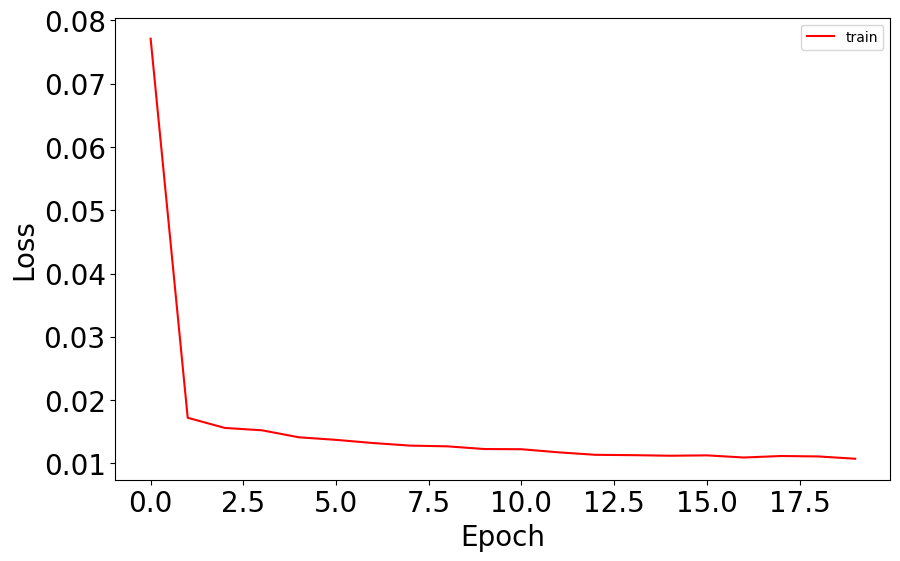

In [36]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)
plt.show()

In [50]:
model.fit(X_train, y_train, batch_size = 16, epochs = 20)

Epoch 1/20
189/189 [==============================] - 0s 2ms/step - loss: 1.1540e-04
Epoch 2/20
189/189 [==============================] - 0s 2ms/step - loss: 1.3433e-04
Epoch 3/20
189/189 [==============================] - 0s 2ms/step - loss: 1.5176e-04
Epoch 4/20
189/189 [==============================] - 0s 2ms/step - loss: 1.1543e-04
Epoch 5/20
189/189 [==============================] - 0s 2ms/step - loss: 1.2579e-04
Epoch 6/20
189/189 [==============================] - 0s 2ms/step - loss: 1.3670e-04
Epoch 7/20
189/189 [==============================] - 0s 2ms/step - loss: 1.1442e-04
Epoch 8/20
189/189 [==============================] - 0s 2ms/step - loss: 1.3797e-04
Epoch 9/20
189/189 [==============================] - 0s 2ms/step - loss: 1.2457e-04
Epoch 10/20
189/189 [==============================] - 0s 2ms/step - loss: 1.1581e-04
Epoch 11/20
189/189 [==============================] - 0s 2ms/step - loss: 1.0401e-04
Epoch 12/20
189/189 [==============================] - 0s 2ms/s

In [51]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
predicted_prices = np.reshape(predicted_prices, -1)

24/24 [==============================] - 0s 1ms/step


In [52]:
acctually_prices = data[split_idx+best_time_step+1:]
acctually_prices = np.reshape(acctually_prices, -1)

In [53]:
# Tính Mean Squared Error
mse = mean_squared_error(acctually_prices, predicted_prices)
print(f"MSE: {mse}")

# Tính MAE
mae = mean_absolute_error(acctually_prices, predicted_prices)
print(f"MAE: {mae}")

#Tính MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
mape = calculate_mape(acctually_prices, predicted_prices)
print(f"MAPE: {mape}")

# Tính R-squared
r2 = r2_score(acctually_prices, predicted_prices)
print(f"R-squared: {r2}")

MSE: 0.9163053477073229
MAE: 0.7076470616848088
MAPE: 0.5832664319961872
R-squared: 0.9602206617230247


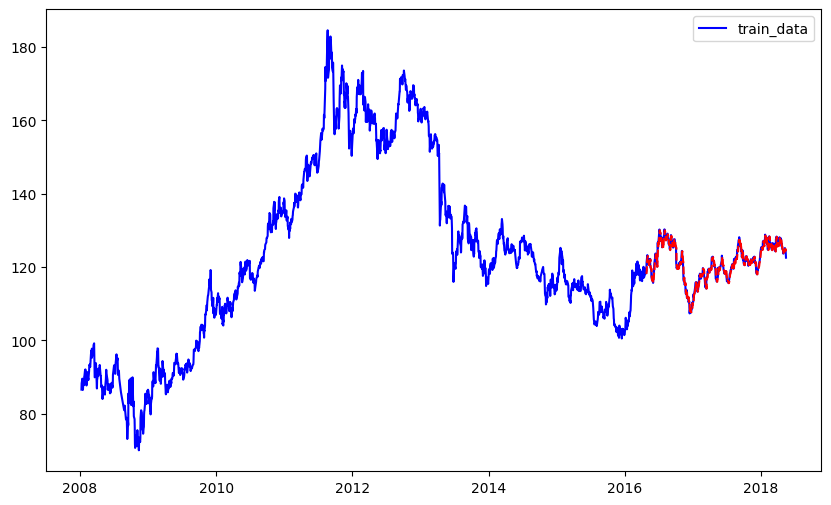

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(time[best_time_step:] , data[best_time_step:],label = "train_data", color = "b")
plt.plot(time[best_time_step+split_idx+1:], predicted_prices, color = "red", linestyle = '--')
plt.legend()
plt.show()